<a href="https://colab.research.google.com/github/Naveenbsm/Deep-Learning-Applications-in-Retinal-Disease-Detection/blob/main/Deep_Learning_Applications_in_Retinal_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Necessary Libraries

In [3]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_dir = '/content/drive/MyDrive/eyedisease'
folders = os.listdir(file_dir)
file_path =[]
labels = []
for folder in folders:
    sub_folder = os.path.join(file_dir, folder)
    filelist = os.listdir(sub_folder)
    for file in filelist:
        f_path = os.path.join(sub_folder, file)
        file_path.append(f_path)
        labels.append(folder)
df =pd.DataFrame({"filepath": file_path, "label":labels})
df.head()

,filepath,label
0,/content/drive/MyDrive/eyedisease/glaucoma/_43...,glaucoma
1,/content/drive/MyDrive/eyedisease/glaucoma/127...,glaucoma
2,/content/drive/MyDrive/eyedisease/glaucoma/197...,glaucoma
3,/content/drive/MyDrive/eyedisease/glaucoma/_11...,glaucoma
4,/content/drive/MyDrive/eyedisease/glaucoma/149...,glaucoma


In [6]:
def load_dataset(file_dir):
    """
    Load file paths and labels from the dataset directory

    Args:
        file_dir (str): Path to the dataset directory

    Returns:
        pd.DataFrame: DataFrame with file paths and labels
    """
    file_paths = []
    labels = []

    folders = os.listdir(file_dir)
    for folder in folders:
        sub_folder = os.path.join(file_dir, folder)
        filelist = os.listdir(sub_folder)

        for file in filelist:
            f_path = os.path.join(sub_folder, file)
            file_paths.append(f_path)
            labels.append(folder)

    return pd.DataFrame({"filepath": file_paths, "label": labels})
df = load_dataset(file_dir)

In [7]:
df.shape

(4217, 2)

## Exploratory Data Analysis

<Axes: xlabel='label'>

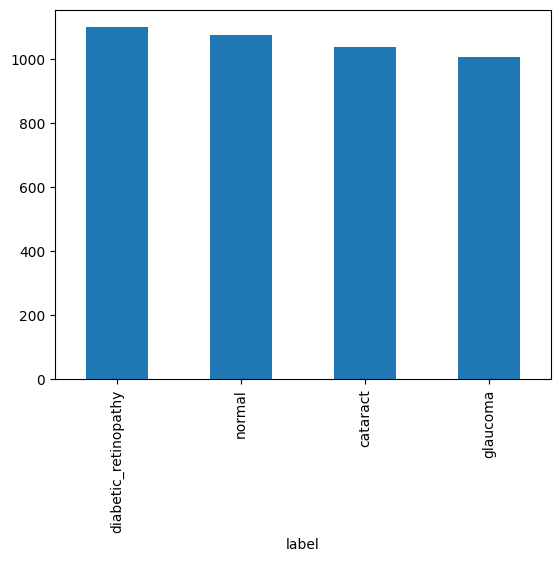

In [8]:
df['label'].value_counts().plot(kind='bar')

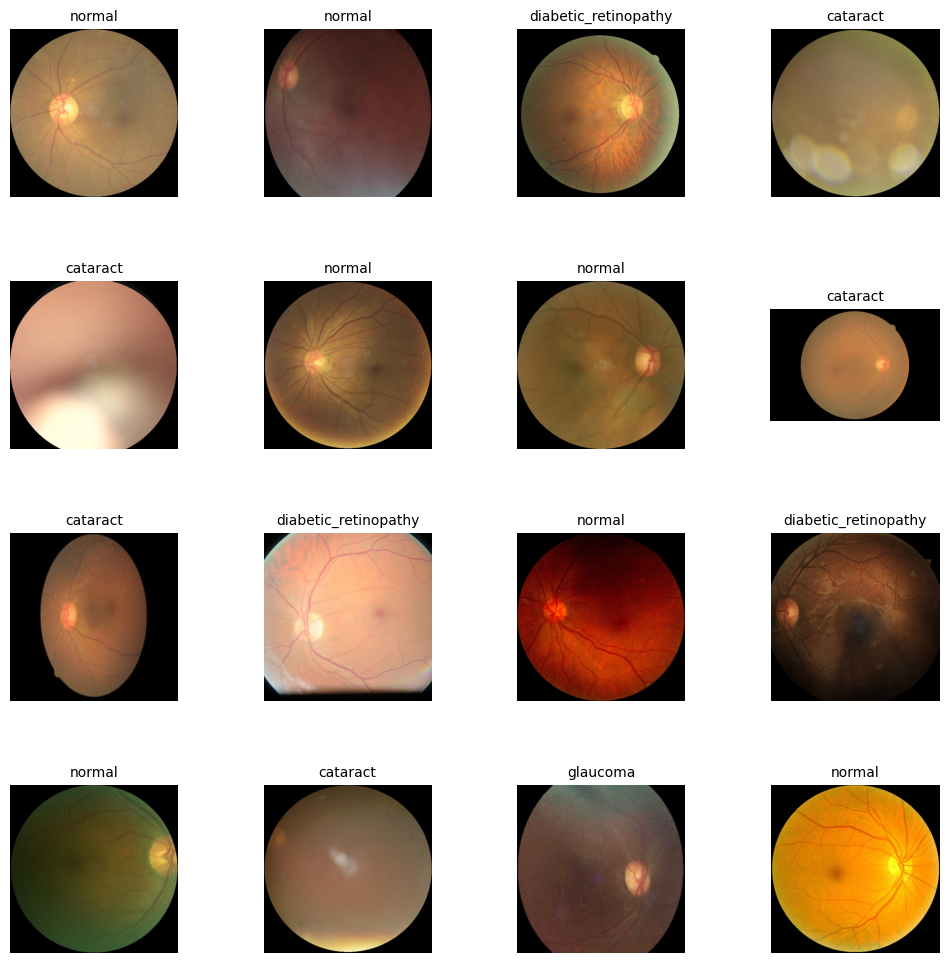

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Randomly sample 16 images from the dataset
sampled_images = df.sample(16).reset_index()

# Set up the grid
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Loop through the grid and plot each image
for i, ax in enumerate(axes.flat):
    img_path = sampled_images['filepath'][i]
    label = sampled_images['label'][i]
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(label, fontsize=10)
    ax.axis('off')  # Hide axis for better visualization

plt.show()


In [10]:
def preprocess_image(image_path, target_size=(128, 128)):
    """
    Preprocess single image with enhancement techniques

    Args:
        image_path (str): Path to the image file
        target_size (tuple): Desired output image size

    Returns:
        np.ndarray: Preprocessed image
    """
    try:
        # Read image with error handling
        image = cv2.imread(image_path)

        # Check if image is loaded successfully
        if image is None:
            print(f"Warning: Unable to read image {image_path}")
            return None

        # Convert to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize with aspect ratio preservation
        h, w = image.shape[:2]
        aspect_ratio = w / h

        # Resize maintaining aspect ratio
        if w > h:
            new_w = target_size[0]
            new_h = int(new_w / aspect_ratio)
        else:
            new_h = target_size[1]
            new_w = int(new_h * aspect_ratio)

        resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # Create blank canvas
        canvas = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)

        # Calculate positioning to center the image
        y_start = (target_size[1] - new_h) // 2
        x_start = (target_size[0] - new_w) // 2

        # Place resized image on canvas
        canvas[y_start:y_start+new_h, x_start:x_start+new_w] = resized

        # Convert to float and normalize
        normalized = canvas.astype(np.float32) / 255.0

        return normalized

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

## Data Preprocessing

In [11]:

def prepare_dataset(file_dir, test_size=0.2, random_state=42):
    """
    Prepare and preprocess the entire dataset

    Args:
        file_dir (str): Path to the dataset directory
        test_size (float): Proportion of dataset for testing
        random_state (int): Random seed for reproducibility

    Returns:
        tuple: Preprocessed and split dataset
    """
    # Load dataset
    df = load_dataset(file_dir)

    # Preprocess images with error handling
    processed_images = []
    processed_labels = []

    for path, label in zip(df['filepath'], df['label']):
        img = preprocess_image(path)
        if img is not None:
            processed_images.append(img)
            processed_labels.append(label)

    # Convert to numpy array
    X = np.array(processed_images)

    # Encode labels
    label_encoder = {label: idx for idx, label in enumerate(sorted(set(processed_labels)))}
    y = np.array([label_encoder[label] for label in processed_labels])

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    return X_train, X_test, y_train, y_test, label_encoder

In [12]:

def data_augmentation(image, num_augmentations=4):
    """
    Perform data augmentation on a single image
        Args:
        image (np.ndarray): Input image
        num_augmentations (int): Number of augmentations to generate

    Returns:
        list: Augmented images
    """
    augmented_images = [image]

    # Geometric Transformations
    # 1. Horizontal Flip
    flipped = cv2.flip(image, 1)
    augmented_images.append(flipped)

    # 2. Rotations
    for angle in [15, -15]:
        # Rotation matrix
        center = (image.shape[1] // 2, image.shape[0] // 2)
        rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, rot_matrix, (image.shape[1], image.shape[0]))
        augmented_images.append(rotated)

    # Color/Intensity Transformations
    # 3. Brightness adjustment
    brightness_low = np.clip(image * 1.2, 0, 1)
    brightness_high = np.clip(image * 0.8, 0, 1)
    augmented_images.extend([brightness_low, brightness_high])

    return augmented_images

In [13]:
def augment_training_data(X_train, y_train):
    """
    Augment training data

    Args:
        X_train (np.ndarray): Training images
        y_train (np.ndarray): Training labels

    Returns:
        tuple: Augmented images and labels
    """
    augmented_images = []
    augmented_labels = []

    for img, label in zip(X_train, y_train):
        # Original image
        augmented_images.append(img)
        augmented_labels.append(label)

        # Generate augmentations
        aug_imgs = data_augmentation(img)
        augmented_images.extend(aug_imgs[1:])  # Skip the first (original) image
        augmented_labels.extend([label] * (len(aug_imgs) - 1))

    return np.array(augmented_images), np.array(augmented_labels)

In [14]:

file_dir = '/content/drive/MyDrive/eyedisease'

# Prepare dataset
X_train, X_test, y_train, y_test, label_encoder = prepare_dataset(file_dir)

# Optional: Apply data augmentation
X_train_aug, y_train_aug = augment_training_data(X_train, y_train)

# Print shapes and details
print("Original training data shape:", X_train.shape)
print("Augmented training data shape:", X_train_aug.shape)
print("Label Encoding:", label_encoder)

Original training data shape: (3373, 128, 128, 3)
Augmented training data shape: (20238, 128, 128, 3)
Label Encoding: {'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}


## Development of CNN, Transfer Learning, and CNN-LSTM models

In [15]:
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

        # Flatten and Dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),

        # Output layer
    layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [16]:
from tensorflow.keras.applications import VGG16
def create_transfer_learning_model(input_shape, num_classes):
    """
    Create Transfer Learning Model using VGG16

    Args:
        input_shape (tuple): Input image shape
        num_classes (int): Number of disease classes

    Returns:
        tf.keras.Model: Compiled transfer learning model
    """
    # Load pre-trained VGG16 model
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model layers
    base_model.trainable = False

    # Add custom top layers
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
        ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [17]:
def create_cnn_lstm_model(input_shape, num_classes):
    """
    Create CNN-LSTM Hybrid Model

    Args:
        input_shape (tuple): Input image shape
        num_classes (int): Number of disease classes

    Returns:
        tf.keras.Model: Compiled CNN-LSTM model
    """
    model = models.Sequential([
        # CNN layers for feature extraction
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
    # Reshape for LSTM
        layers.Reshape((-1, 128)),

        # LSTM layers
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),

        # Dense layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

## Model Testing and Evaluation

In [18]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_evaluate_model(X_train, X_test, y_train, y_test, model_func, model_name):
    """
    Train and evaluate a specific model

    Args:
        X_train (np.ndarray): Training images
        X_test (np.ndarray): Testing images
        y_train (np.ndarray): Training labels
        y_test (np.ndarray): Testing labels
        model_func (callable): Function to create model
        model_name (str): Name of the model

    Returns:
        dict: Model performance metrics
    """
    # Prepare data for training
    num_classes = len(np.unique(y_train))
    y_train_cat = to_categorical(y_train, num_classes=num_classes)
    y_test_cat = to_categorical(y_test, num_classes=num_classes)

    # Split training data into train and validation sets
    X_train_final, X_val, y_train_cat_final, y_val_cat = train_test_split(
        X_train, y_train_cat, test_size=0.2, random_state=42
    )

    # Create model
    model = model_func(X_train.shape[1:], num_classes)

    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )

    # Fit the data generator on training data
    datagen.fit(X_train_final)

    # Train model
    history = model.fit(
        datagen.flow(X_train_final, y_train_cat_final, batch_size=32),
        epochs=15,
        validation_data=(X_val, y_val_cat),
        verbose=1
    )

    # Evaluate model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test_cat, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

    # ROC AUC (one-vs-rest)
    try:
        roc_auc = roc_auc_score(y_test_cat, y_pred, multi_class='ovr', average='weighted')
    except Exception as e:
        print(f"ROC AUC calculation error: {e}")
        roc_auc = None

    # Confusion Matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)

    # Visualize Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    plt.close()

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'history': history
    }


Training Custom CNN...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.3694 - loss: 2.1452 - val_accuracy: 0.2578 - val_loss: 2.3573
Epoch 2/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.4336 - loss: 1.4352 - val_accuracy: 0.2578 - val_loss: 4.6773
Epoch 3/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.4262 - loss: 1.2813 - val_accuracy: 0.2607 - val_loss: 5.0577
Epoch 4/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.4638 - loss: 1.2218 - val_accuracy: 0.2785 - val_loss: 4.4782
Epoch 5/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.4664 - loss: 1.1858 - val_accuracy: 0.3348 - val_loss: 2.5022
Epoch 6/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.4780 - loss: 1.1387 - val_accuracy: 0.3748 - val_loss: 1.6219
Epoch 7/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.4406 - loss: 1.1610 - val_accuracy: 0.4830 - val_loss: 1.1688
Epoch 8/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.5144 - loss: 1.0896 - val_accuracy: 0.5022 - val_loss: 1.

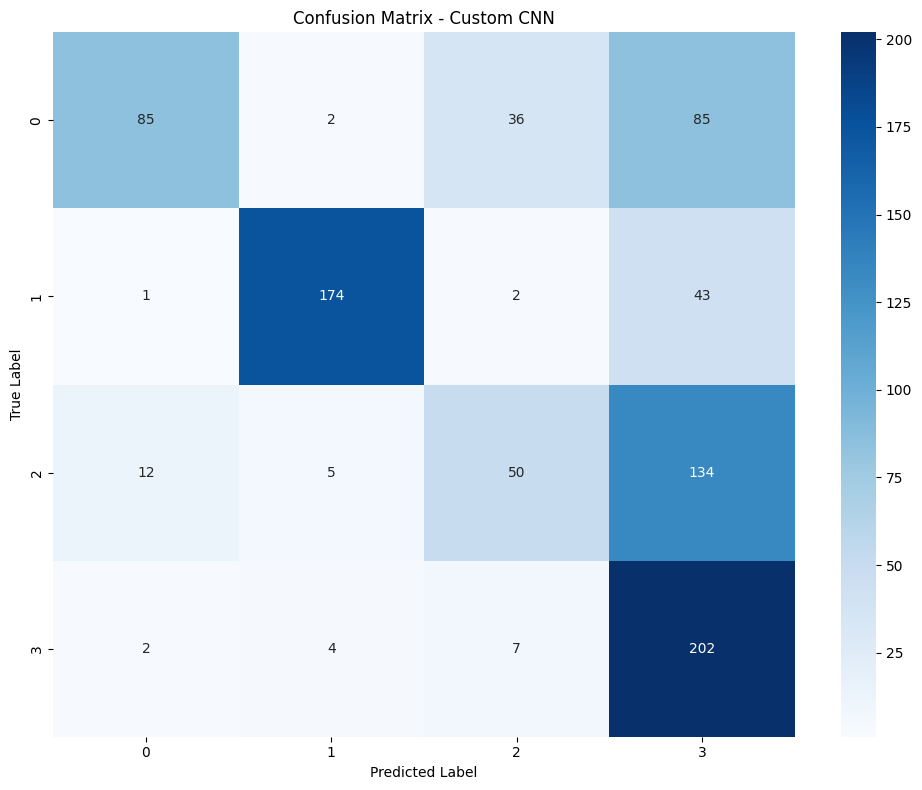


Training Transfer Learning (VGG16)...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 636s 7s/step - accuracy: 0.3851 - loss: 1.3698 - val_accuracy: 0.6015 - val_loss: 1.0745
Epoch 2/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 682s 7s/step - accuracy: 0.5479 - loss: 1.0386 - val_accuracy: 0.6193 - val_loss: 0.9469
Epoch 3/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 627s 7s/step - accuracy: 0.6308 - loss: 0.8791 - val_accuracy: 0.6504 - val_loss: 0.8754
Epoch 4/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 683s 7s/step - accuracy: 0.6588 - loss: 0.8280 - val_accuracy: 0.6741 - val_loss: 0.7779
Epoch 5/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 631s 7s/step - accuracy: 0.6714 - loss: 0.7755 - val_accuracy: 0.6815 - val_loss: 0.7708
Epoch 6/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 632s 7s/step - accuracy: 0.6902 - loss: 0.7426 - val_accuracy: 0.6889 - val_loss: 0.7575
Epoch 7/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 680s 7s/step - accuracy: 0.7230 - loss: 0.6829 - val_accuracy: 0.6741 - val_loss: 0.7890
Epoch 8/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 680s 7s/step - accuracy: 0.7234 - loss: 0.6777 - val_accuracy: 0.6933 - val_loss: 0.

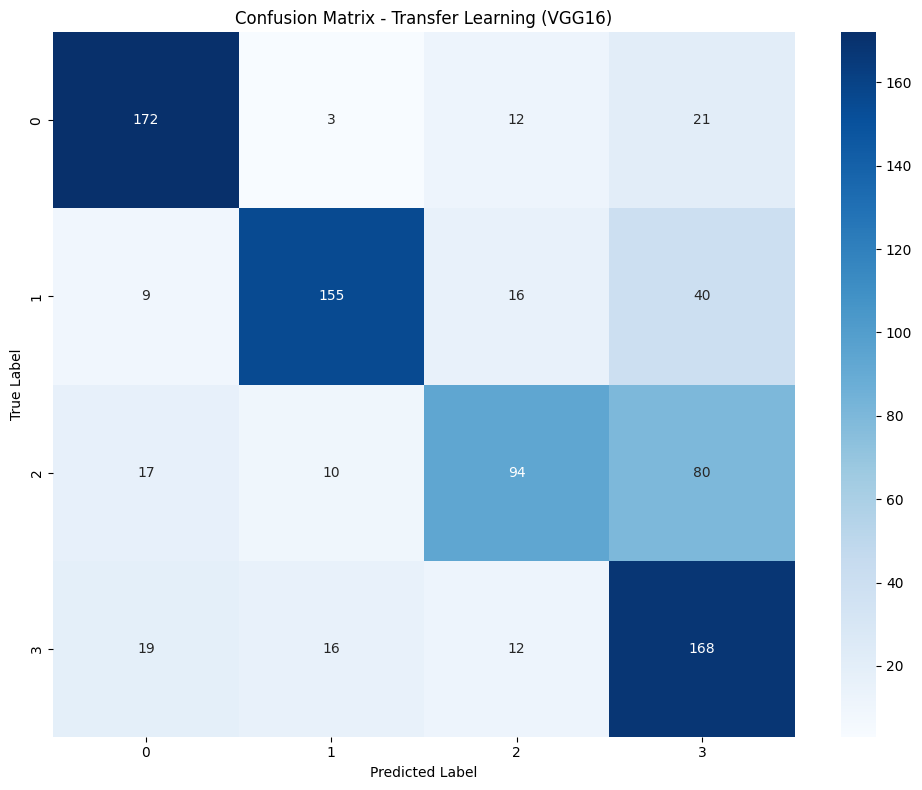


Training CNN-LSTM...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.2663 - loss: 1.3851 - val_accuracy: 0.3763 - val_loss: 1.3686
Epoch 2/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.3227 - loss: 1.3683 - val_accuracy: 0.3393 - val_loss: 1.3208
Epoch 3/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.3272 - loss: 1.3302 - val_accuracy: 0.4222 - val_loss: 1.2753
Epoch 4/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.3818 - loss: 1.2858 - val_accuracy: 0.4741 - val_loss: 1.1844
Epoch 5/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.4506 - loss: 1.2073 - val_accuracy: 0.4830 - val_loss: 1.1577
Epoch 6/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.4652 - loss: 1.1747 - val_accuracy: 0.4696 - val_loss: 1.1762
Epoch 7/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.4602 - loss: 1.1773 - val_accuracy: 0.4919 - val_loss: 1.1350
Epoch 8/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5125 - loss: 1.0912 - val_accuracy: 0.4800 - val_loss: 1.

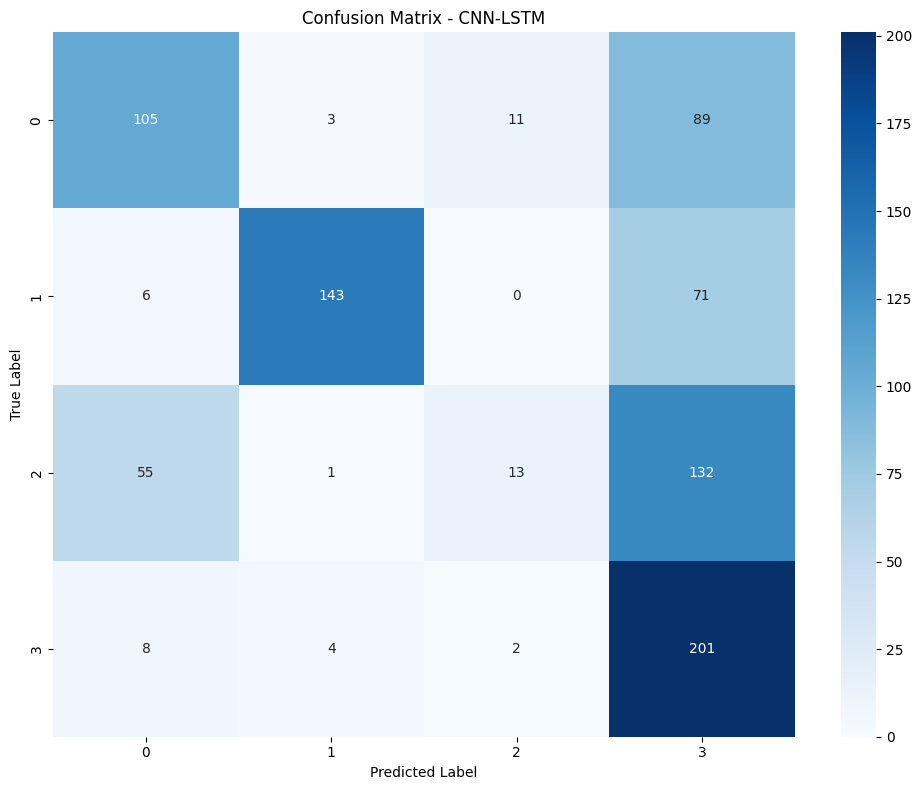


Experimental Results:

Model: Custom CNN
Accuracy: 0.6055
F1 Score: 0.5920
ROC AUC: 0.8505

Model: Transfer Learning (VGG16)
Accuracy: 0.6979
F1 Score: 0.6965
ROC AUC: 0.9077

Model: CNN-LSTM
Accuracy: 0.5474
F1 Score: 0.5083
ROC AUC: 0.8088


In [19]:

def main():
    # File directory for dataset
    file_dir = '/content/drive/MyDrive/eyedisease'

# Prepare dataset
    X_train, X_test, y_train, y_test, label_encoder = prepare_dataset(file_dir)

    # Model configurations
    models_to_test = [
        (create_cnn_model, 'Custom CNN'),
        (create_transfer_learning_model, 'Transfer Learning (VGG16)'),
        (create_cnn_lstm_model, 'CNN-LSTM')
    ]

    # Store results
    results = []
# Run experiments
    for model_func, model_name in models_to_test:
        print(f"\nTraining {model_name}...")

        # Train and evaluate model
        model_results = train_and_evaluate_model(
            X_train, X_test, y_train, y_test,
            model_func, model_name
        )
        results.append(model_results)

    # Summarize results
    print("\nExperimental Results:")
    for result in results:
        print(f"\nModel: {result['model_name']}")
        print(f"Accuracy: {result['accuracy']:.4f}")
        print(f"F1 Score: {result['f1_score']:.4f}")
        print(f"ROC AUC: {result['roc_auc']:.4f}" if result['roc_auc'] is not None else "ROC AUC: N/A")

if __name__ == '__main__':
    main()